# Antes de empezar

Vete a la pestaña "Runtime" (junto a "Herramientas") y selecciona "Cambiar entorno de trabajo" a "GPU T4".

# Preparación

In [21]:
# @title Carga los datos de toxicidad
# @markdown Los datos que vamos a utilizar provienen de un
# @markdown estudio acerca de predicción de medicamentos que produjeron daño hepático. Los estamos descargando de esta collección
# @markdown [TDC DILI](https://tdcommons.ai/single_pred_tasks/tox/#dili-drug-induced-liver-injury),
# @markdown pero el artículo original es [Xu, Youjun, et al. “Deep learning for drug-induced liver injury.” Journal of chemical information and modeling 55.10 (2015): 2085-2093](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00238).
!pip install -q PyTDC==0.4.1

from tdc.single_pred import Tox
import pandas as pd

data = Tox(name = 'DILI', path='.')
df = pd.read_csv('dili.tab', sep='\t')

Downloading...
100%|██████████| 26.7k/26.7k [00:00<00:00, 124kiB/s] 
Loading...
Done!


In [22]:
# @title Instala los paquetes necesarios para trabajar
# @markdown Cuando pulses "play", se instalarán los principales
# @markdown paquetes que necesitamos para trabajar en esta libreta: Pandas
# @markdown (para cargar los datos), Transformers (para cargar los modelos de lenguaje y
# @markdown re-entrenarlos), Seaborn (para crear gráficos), RDKit para analizar las moléculas y
# @markdown Hestia-GOOD (para dividir los datos en "entrenamiento" y "evaluación")
# %%capture

!pip install -q pandas hestia-good
# !pip install git+https://github.com/IBM/AutoPeptideML@apml-2
!pip install -q seaborn rdkit
!pip install -q transformers accelerate datasets

# Análisis de datos

In [23]:
# @title 1. ¿Qué forma tienen los datos?
# @markdown Antes de empezar a entrenar nada, es importante entender con qué tipo de datos estamos trabajando. Vamos a empezar viendo una tabla con los datos.
df.head()

,Drug_ID,Drug,Y
0,187.0,CC(=O)OCC[N+](C)(C)C,0.0
1,247.0,C[N+](C)(C)CC(=O)[O-],0.0
2,298.0,O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl,0.0
3,338.0,O=C(O)c1ccccc1O,0.0
4,444.0,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,0.0


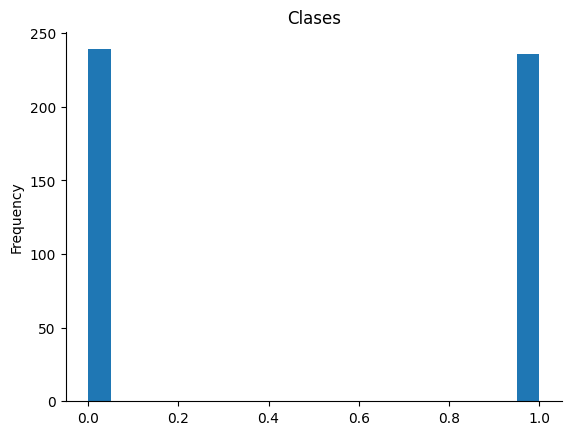

In [24]:
# @title 2. Representación gráfica de las clases
# @markdown Es importante que las clases estén equilibradas. En este caso, lo están así que no tenemos que preocuparnos más.

from matplotlib import pyplot as plt
df['Y'].plot(kind='hist', bins=20, title='Clases')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [25]:
# @title 3. División de los datos en entrenamiento, validación y evaluación
# @markdown Vamos a utilizar ahora Hestia para dividir nuestros datos. Vamos a medir la similitud entre las moléculas en base a huellas moleculares ECFP con radio 2 y 1,024 bits. Si tenéis interés podéis probar con diferentes configuraciones, veréis que no hay cambios sustanciales.
# @markdown - Fingerprint:
# @markdown     - ECFP
# @markdown     - MAPc
# @markdown - Radius:
# @markdown    - 2 a 6
# @markdown - Number of bits:
# @markdown    - 256 a 2048
# @markdown - Threshold:
# @markdown    - 0.1 a 0.9

from hestia.partition import ccpart, random_partition
from hestia.similarity import molecular_similarity

sim_df = molecular_similarity(
    df_query=df,
    fingerprint='ecfp', # o mapc
    radius=2, # Probad otros radios, números enteros
    bits=2048, # Probad 256 a 2048, múltiplos de 2
    df=df,
    field_name='Drug',
    verbose=3
)

train, test, clusters = ccpart(
    df=df,
    sim_df=sim_df,
    test_size=0.2,
    threshold=0.4, # Probad otros thresholds 0.1 - 0.9
)
train_df, test_df = df.iloc[train, :].copy().reset_index(), df.iloc[test, :].copy().reset_index()
train, val = random_partition(
    train_df, test_size=0.1, random_state=42
)
train_df, val_df = df.iloc[train, :].copy().reset_index(), df.iloc[val, :].copy().reset_index()

print(f'Tamaño del entrenamiento: {len(train_df):,}')
print(f'Tamaño de la validación: {len(val_df):,}')
print(f'Tamaño de la evaluación: {len(test_df):,}')


Calculating molecular similarities using ecfp with 2,048 bits, radius 2 and tanimoto index...


Similarity calculation: 100%|██████████| 475/475 [00:00<00:00, 2.50kit/s]


Tamaño del entrenamiento: 342
Tamaño de la validación: 39
Tamaño de la evaluación: 94


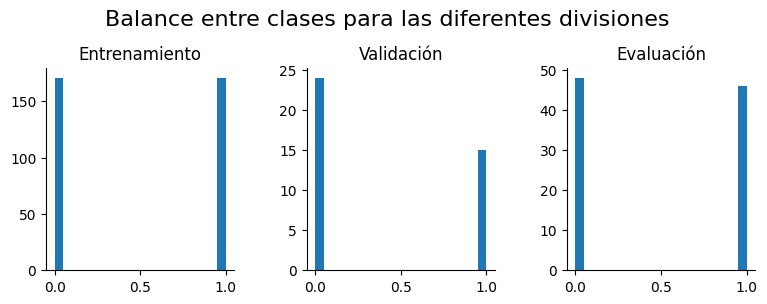

In [26]:
# @title 4. Representación gráfica de las clases
%matplotlib inline

from matplotlib import pyplot as plt
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 3, dpi=100)
fig.suptitle("Balance entre clases para las diferentes divisiones", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

fig.set_size_inches(8, 3)
ax[0].hist(train_df['Y'], bins=20)
ax[0].set_title('Entrenamiento')
ax[1].hist(val_df['Y'], bins=20)
ax[1].set_title('Validación')
ax[2].hist(test_df['Y'], bins=20)
ax[2].set_title('Evaluación')
for i in range(3):
  ax[i].spines[['top', 'right',]].set_visible(False)
plt.show()

La conclusión que podemos sacar es que entrenamiento está equilibrada; mientras que entre validación y evaluación existe algo de desequilibrio. No es un desequilibrio grande, así que no tenemos que preocuparnos por él. Pero es importante saber que existe cuando interpretemos los resultados


# Entrenamiento

In [32]:
# @title 1. Definir métricas
# @markdown Este código define varias métricas para el modelo. Algunas de ellas no las vamos a usar.

from typing import Any, Callable, List

import numpy as np
import torch
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import (f1_score, matthews_corrcoef,
                             precision_recall_curve, accuracy_score,
                             mean_squared_error, mean_absolute_error,
                             roc_auc_score, auc, confusion_matrix)
from sklearn.metrics.pairwise import cosine_similarity
import transformers as hf


class CustomTrainer(hf.Trainer):
    def save_model(self, output_dir: str = None, _internal_call: bool = False):
        device = self.model.device
        self.model = self.model.cpu()
        super().save_model(output_dir, _internal_call)
        self.model = self.model.to(device)


class Metrics:
    multilabel = False

    def __init__(self):
        self.metrics = {}

    def add_metric(self, name: str, metric: Callable):
        self.metrics[name] = metric

    def get_metrics(self, names: List[str], multilabel: bool = False):
        metrics = Metrics()
        metrics.multilabel = multilabel
        for name in names:
            if name in self.metrics:
                metrics.add_metric(name, self.metrics[name])
            else:
                raise ValueError(f"Metric: {name} not supported.",
                                 " Please use one of the following: ",
                                 f" {list(self.metrics.keys())}")
        return metrics

    def todict(self) -> dict:
        output = {}
        for name, fun in self.metrics.items():
            output[name] = fun
        return output

    def __call__(self, eval_prediction) -> Any:
        output = {}

        preds = eval_prediction.predictions
        refs = eval_prediction.label_ids
        if isinstance(preds, tuple):
            preds = preds[0]

        if len(preds.shape) < 2:
            pass
        elif preds.shape[1] > 1 and not self.multilabel:
            preds = np.argmax(preds, axis=1)

        if preds.dtype != refs.dtype or self.multilabel:
            preds = preds > (1 / preds.shape[1])

        for key, value in self.metrics.items():
          if key == 'cm':
            output2 = value(preds, refs)
            for k2, v2 in output2.items():
              output[k2] = v2
          else:
            output[key] = value(preds, refs)[key]
        return output


def acc(predictions, references, **kwargs):
    return {"acc": accuracy_score(references, predictions)}


def auroc(predictions, references, **kwargs):
    return {"auroc": roc_auc_score(references, predictions)}


def cm_fun(predictions, references, **kwargs):
  cm = confusion_matrix(predictions, references)
  return {'tn': cm[0, 0], 'fp': cm[0, 1], 'tp': cm[1, 1], 'fn': cm[1, 0]}

def tn(predictions, references, **kwargs):
  predictions = predictions < 0.5
  references = references < 0.5
  return {'tn': np.sum(predictions == references)}

def fp(predictions, references, **kwargs):
  predictions = predictions > 0.5
  references = references < 0.5
  return {'fp': np.sum(predictions == references)}

def fn(predictions, references, **kwargs):
  predictions = predictions < 0.5
  references = references > 0.5
  return {'fn': np.sum(predictions == references)}

def precision_at_l5(predictions, references, sequence_lengths, **kwargs):
    prev_pos = 0
    correct = 0
    total = 0
    for idx, label in enumerate(references):
        pred = predictions[prev_pos:prev_pos + label.shape[0] ** 2].toarray().reshape(label.shape[0], label.shape[0], 1)
        label = torch.from_numpy(label)
        prev_pos += label.shape[0] ** 2
        length = sequence_lengths[idx]
        pred = torch.from_numpy(pred).float()
        prob = torch.nn.functional.softmax(pred).view(-1)
        most_likely = prob.topk(length // 5, sorted=False)
        selected = label.view(-1).gather(0, most_likely.indices)
        correct += selected.sum().float()
        total += selected.numel()

    return correct / total


def cosine(predictions, references, **kwargs):
    cosine = list(map(lambda x: cosine_similarity(x[0].reshape(1, -1),
                                                  x[1].reshape(1, -1)).item(),
                                                  predictions))
    cosine, references = np.array(cosine), np.array(references)
    score, _ = spearmanr(references, cosine)
    return {'cos': float(score)}


def manhattan(predictions, references, **kwargs):
    dist = list(map(lambda x: cdist(x[0].reshape(1, -1), x[1].reshape(1, -1),
                                    'cityblock'), predictions))
    norm = list(map(lambda x: (np.linalg.norm(x[0].reshape(1, -1), 1) +
                               np.linalg.norm(x[1].reshape(1, -1), 1)),
                               predictions))

    dist = np.array([1 - (d / n).item() for d, n in zip(dist, norm)])
    # dist = np.array(dist) / (np.linalg.norm(predictions) +
    #                          np.linalg.norm(predictions))
    if isinstance(references, list):
        references = np.array(references)
        # references = references.reshape(-1, 1)
    score, _ = spearmanr(dist, references)
    return {'manhattan': float(score)}


def euclidean(predictions, references, **kwargs):
    dist = list(map(lambda x: cdist(x[0].reshape(1, -1), x[1].reshape(1, -1),
                                    'euclidean'), predictions))
    norm = list(map(lambda x: (np.linalg.norm(x[0].reshape(1, -1), 2) +
                               np.linalg.norm(x[1].reshape(1, -1), 2)),
                               predictions))

    dist = np.array([1 - (d / n).item() for d, n in zip(dist, norm)])
    if isinstance(references, list):
        references = np.array(references)

    score, _ = spearmanr(dist, references)
    return {'euclidean': float(score)}


def f1_max(predictions, references, **kwargs):
    beta = 1.0
    fbeta = 0.0
    for i in range(references.shape[-1]):
        if np.sum(references[:, i]) == 0.0:
            continue
        precision, recall, _ = precision_recall_curve(
            y_true=references[:, i], probas_pred=predictions[:, i]
        )
        numerator = (1 + beta**2) * (precision * recall)
        denominator = ((beta**2 * precision) + recall)
        a = np.divide(numerator, denominator,
                      out=np.zeros_like(numerator),
                      where=(denominator != 0))
        fbeta += np.nanmax(a / references.shape[1])
    return {"f1_max": float(fbeta)}


def f1_binary(predictions, references, **kwargs):
    score = f1_score(
        references, predictions, average='binary', zero_division=0
    )
    return {"f1": float(score)}


def f1_weighted(predictions, references, **kwargs):
    score = f1_score(references, predictions, average='weighted', zero_division=0, **kwargs)
    return {"f1_weighted": float(score) if score.size == 1 else score}


def mcc(predictions, references, **kwargs):
    score = matthews_corrcoef(
        references, predictions
    )
    return {"mcc": float(score)}


def spcc(predictions, references, **kwargs):
    corr, p_value = spearmanr(references, predictions)
    return {"spcc": float(corr)}


def pcc(predictions, references, **kwargs):
    corr, p_value = pearsonr(references, predictions)
    return {"pcc": float(corr)}


def mse(predictions, references, **kwargs):
    return {'mse': mean_squared_error(references, predictions)}


def mae(predictions, references, **kwargs):
    return {'mae': mean_absolute_error(references, predictions)}


def aupr(predictions, references, **kwargs):
    precision, recall, _ = precision_recall_curve(
        y_true=references, probas_pred=predictions
    )
    return {'aupr': auc(precision, recall)}


metrics_collection = Metrics()
metrics_collection.add_metric('acc', acc)
metrics_collection.add_metric('auroc', auroc)
metrics_collection.add_metric('f1', f1_binary)
metrics_collection.add_metric('f1_weighted', f1_weighted)
metrics_collection.add_metric('f1_max', f1_max)
metrics_collection.add_metric('mcc', mcc)
metrics_collection.add_metric('spcc', spcc)
metrics_collection.add_metric('pcc', pcc)
metrics_collection.add_metric('euclidean', euclidean)
metrics_collection.add_metric('cosine', cosine)
metrics_collection.add_metric('manhattan', manhattan)
metrics_collection.add_metric('mse', mse)
metrics_collection.add_metric('aupr', aupr)
metrics_collection.add_metric('mae', mae)
metrics_collection.add_metric('cm', cm_fun)


In [33]:
# @title 2. Preparar y configurar el modelo de lenguaje
# @markdown Ahora vamos a descargar el modelo de lenguaje para moléculas,
# @markdown [MolFormer-XL](https://huggingface.co/ibm/MoLFormer-XL-both-10pct) o [ChemBERTa-2](https://huggingface.co/DeepChem/ChemBERTa-77M-MTR).
# @markdown Utilizamos el paquete `transformers` de HuggingFace que automatiza y simplifica un montón de operaciones.

import copy

import transformers as hf
from datasets import Dataset

model_name = 'ibm/MoLFormer-XL-both-10pct' # Probad DeepChem/ChemBERTa-77M-MTR
num_labels = 2
metrics = ['acc', 'mcc', 'f1', 'aupr', 'auroc',
           'cm']

tokenizer = hf.AutoTokenizer.from_pretrained(
  model_name, max_length=250, trust_remote_code=True
  )

model = hf.AutoModelForSequenceClassification.from_pretrained(
  model_name, num_labels=num_labels, trust_remote_code=True
)
hf_args = hf.TrainingArguments(
        output_dir='molformer',
        learning_rate=1e-4,
        label_names=['labels'],
        metric_for_best_model='mcc' if num_labels > 1 else 'spcc',
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=50,
        greater_is_better=True,
        eval_accumulation_steps=1,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        report_to='tensorboard',
    )
ds = {
    'train': Dataset.from_pandas(train_df),
    'val': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
}
for split in ds.keys():
    ds[split] = ds[split].map(
        lambda x: tokenizer(x['Drug'], truncation=True, padding='max_length',
                            max_length=210)
    )
    ds[split] = ds[split].rename_column('Y', 'labels')
    ds[split] = ds[split].class_encode_column('labels')
    ds[split].set_format(
        type='pt', columns=['input_ids', 'attention_mask', 'labels']
    )

trainer = CustomTrainer(
    copy.deepcopy(model),
    args=hf_args,
    train_dataset=ds['train'],
    eval_dataset=ds['val'],
    compute_metrics=metrics_collection.get_metrics(metrics),
    callbacks=[hf.EarlyStoppingCallback(5)]
)



Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/342 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/342 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/342 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/39 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/94 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/94 [00:00<?, ? examples/s]

In [34]:
# @title 3. Entrenamiento
# @markdown Finalmente vamos a entrenar el modelo. Si miráis el código, esta parte es sencilla.

values = trainer.train()
trainer._load_best_model()


Epoch,Training Loss,Validation Loss,Acc,Mcc,F1,Aupr,Auroc,Tn,Fp,Tp,Fn
1,No log,0.488730,0.794872,0.626203,0.777778,0.428205,0.820833,17,1,14,7
2,No log,0.331595,0.897436,0.783333,0.866667,0.507692,0.891667,22,2,13,2
3,No log,0.369909,0.897436,0.793060,0.875000,0.506637,0.904167,21,1,14,3
4,No log,0.399529,0.897436,0.793060,0.875000,0.506637,0.904167,21,1,14,3
5,No log,0.459043,0.923077,0.840710,0.903226,0.532372,0.925000,22,1,14,2
6,No log,0.541586,0.948718,0.891667,0.933333,0.561538,0.945833,23,1,14,1
7,No log,0.812072,0.846154,0.705663,0.823529,0.463293,0.862500,19,1,14,5
8,No log,0.720185,0.923077,0.840710,0.903226,0.532372,0.925000,22,1,14,2
9,No log,0.736077,0.923077,0.840710,0.903226,0.532372,0.925000,22,1,14,2
10,No log,0.732549,0.923077,0.836703,0.896552,0.538645,0.912500,23,2,13,1


# Evaluación

In [1]:
# @title 1. Varias métricas
# @markdown Finalmente, el examen final para nuestro modelo; cómo de bien es capaz de generalizar a moléculas que no se parecen a las que ha visto durante el entrenamiento.

metrics = trainer.evaluate(eval_dataset=ds['test'], metric_key_prefix='test')
met_df = pd.DataFrame([metrics])
met_df.head()

NameError: name 'trainer' is not defined

In [ ]:
# @title 2. Representación gráfica de la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
cm = np.array([[metrics['test_tn'], metrics['test_fp']],
              [metrics['test_fn'], metrics['test_tp']]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Negative', 'Positive'])
disp.plot()

plt.show()